Mostly a clone of the REPAIR notebook found here: 
[LINK](https://github.com/KellerJordan/REPAIR/blob/master/notebooks/Merge-ResNet50-ImageNet.ipynb).
One of the main takeways of our work is the comparison between the accuracies
of the merged networks in this notebook and the linked reference.

We use a pretrained ResNet50 from torchvision here, alleviating the need for training an own model to run this notebook. You will need imagenet data processed according to [the official pytorch instructions](https://github.com/pytorch/examples/tree/main/imagenet).

In [1]:
# path to imagenet processed according to 
# https://github.com/pytorch/examples/tree/main/imagenet
# change as needed
imagenet_dir = './imagenet_path.link'

In [2]:
from pathlib import Path
imagenet_dir = Path(imagenet_dir)

In [3]:
from tqdm import tqdm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import autocast
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models

## Load data & models

In [4]:
model_str = 'resnet50'
weights_str = 'ResNet50_Weights.IMAGENET1K_V2'

train_dir = imagenet_dir / 'train'
val_dir = imagenet_dir / 'val'

weights = torchvision.models.get_weight(weights_str)
preprocessing = weights.transforms()

dataset_train = torchvision.datasets.ImageFolder(
    train_dir,
    preprocessing,
)

dataset_val = torchvision.datasets.ImageFolder(
    val_dir,
    preprocessing,
)

In [5]:
dataset_train_small = torch.utils.data.Subset(
    dataset_train, np.random.choice(len(dataset_train), 5000, replace=False)
)

In [6]:
train_loader = torch.utils.data.DataLoader(
    dataset_train_small,
    batch_size=200,
    shuffle=True,
    num_workers=4,
)
val_loader = torch.utils.data.DataLoader(
    dataset_val,
    batch_size=200,
    shuffle=False,
    num_workers=4,
)

In [7]:
# evaluates accuracy
def evaluate(model, loader=val_loader, tta=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            if tta:
                outputs = (outputs + model(inputs.flip(3)))/2
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
    return correct / total

# evaluates acc and loss
def evaluate2(model, loader=val_loader, tta=False):
    model.eval()
    losses = []
    correct = 0
    total = 0
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            outputs = model(inputs.cuda())
            if tta:
                outputs = (outputs + model(inputs.flip(3)))/2
            pred = outputs.argmax(dim=1)
            correct += (labels.cuda() == pred).sum().item()
            total += len(labels)
            loss = F.cross_entropy(outputs, labels.cuda())
            losses.append(loss.item())
    return correct / total, np.array(losses).mean()

def full_eval(model):
    tr_acc, tr_loss = evaluate2(model, loader=train_loader)
    te_acc, te_loss = evaluate2(model, loader=val_loader)
    return (100*tr_acc, tr_loss, 100*te_acc, te_loss)

def full_eval2(model):
    return '(%s)' % ', '.join(['%.2f' % x for x in full_eval(model)])

409


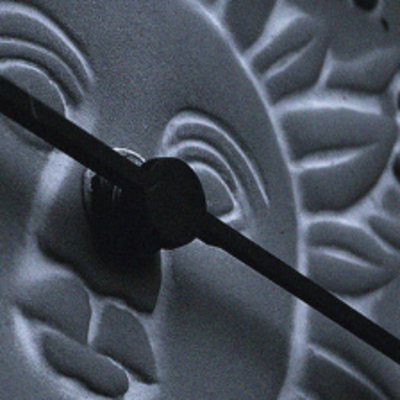

In [8]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])
denormalize = T.Normalize(-IMAGENET_MEAN/IMAGENET_STD, 1/IMAGENET_STD)

images, labels = next(iter(train_loader))
print(labels[8].item())

img_a = denormalize(images[8]).float()
img_a = img_a.permute(1, 2, 0)
img_a = img_a.cpu().numpy()
img_a = (255 * img_a).astype(np.uint8)
Image.fromarray(img_a).resize((400, 400))

In [9]:
def resnet50():
    model = torchvision.models.resnet50(weights=None)
    return model.cuda().eval()

def get_blocks(net):
    return nn.Sequential(nn.Sequential(net.conv1, net.bn1, net.relu, net.maxpool),
                         *net.layer1, *net.layer2, *net.layer3, *net.layer4)

### Matching code

In [10]:
# Given two networks net0, net1 which each output a feature map of shape NxCxWxH,
# this will reshape both outputs to (N*W*H)xC
# and then compute a CxC correlation matrix between the two
def run_corr_matrix(net0, net1):
    n = len(train_loader)
    with torch.no_grad():
        net0.eval()
        net1.eval()
        for i, (images, _) in enumerate(tqdm(train_loader)):
            
            img_t = images.float().cuda()
            out0 = net0(img_t).double()
            out0 = out0.permute(0, 2, 3, 1).reshape(-1, out0.shape[1])
            out1 = net1(img_t).double()
            out1 = out1.permute(0, 2, 3, 1).reshape(-1, out1.shape[1])

            # save batchwise first+second moments and outer product
            mean0_b = out0.mean(dim=0)
            mean1_b = out1.mean(dim=0)
            sqmean0_b = out0.square().mean(dim=0)
            sqmean1_b = out1.square().mean(dim=0)
            outer_b = (out0.T @ out1) / out0.shape[0]
            if i == 0:
                mean0 = torch.zeros_like(mean0_b)
                mean1 = torch.zeros_like(mean1_b)
                sqmean0 = torch.zeros_like(sqmean0_b)
                sqmean1 = torch.zeros_like(sqmean1_b)
                outer = torch.zeros_like(outer_b)
            mean0 += mean0_b / n
            mean1 += mean1_b / n
            sqmean0 += sqmean0_b / n
            sqmean1 += sqmean1_b / n
            outer += outer_b / n

    cov = outer - torch.outer(mean0, mean1)
    std0 = (sqmean0 - mean0**2).sqrt()
    std1 = (sqmean1 - mean1**2).sqrt()
    corr = cov / (torch.outer(std0, std1) + 1e-4)
    return corr

In [11]:
def get_layer_perm1(corr_mtx):
    corr_mtx_a = corr_mtx.cpu().numpy()
    corr_mtx_a = np.nan_to_num(corr_mtx_a)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(corr_mtx_a, maximize=True)
    assert (row_ind == np.arange(len(corr_mtx_a))).all()
    perm_map = torch.tensor(col_ind).long()
    return perm_map

# returns the channel-permutation to make layer1's activations most closely
# match layer0's.
def get_layer_perm(net0, net1):
    corr_mtx = run_corr_matrix(net0, net1)
    return get_layer_perm1(corr_mtx)

In [12]:
def permute_output(perm_map, conv, bn=None):
    pre_weights = [conv.weight]
    if bn is not None:
        pre_weights.extend([bn.weight, bn.bias, bn.running_mean, bn.running_var])
    for w in pre_weights:
        w.data = w[perm_map]

def permute_input(perm_map, layer):
    w = layer.weight
    w.data = w[:, perm_map]

## Match neurons

In [13]:
# Load a single resnet and flip its filters horizontally to obtain a second.
model0 = torchvision.models.get_model(model_str, weights=weights_str, num_classes=1000)
model0.eval().cuda()

model1 = torchvision.models.get_model(model_str, weights=weights_str, num_classes=1000)
model1.eval().cuda()
for m in model1.modules():
    if isinstance(m, torch.nn.Conv2d):
        m.weight.data = m.weight.data.flip(3)

blocks0 = get_blocks(model0)
blocks1 = get_blocks(model1)
evaluate(model0), evaluate(model1)

(0.80856, 0.80524)

In [14]:
def mix_weights(model, alpha, sd0, sd1):
    sd_alpha = {k: (1 - alpha) * sd0[k].cuda() + alpha * sd1[k].cuda()
                for k in sd0.keys()}
    model.load_state_dict(sd_alpha)

In [15]:
model_m = resnet50()
mix_weights(model_m, .5, model0.state_dict(), model1.state_dict())

print('Accuracy of merged model, without permuting channels in the flipped net:')
evaluate(model_m)

Accuracy of merged model, without permuting channels in the flipped net:


0.00938

### intrablock channels

In [16]:
for k in range(1, len(blocks1)):
    block0 = blocks0[k]
    block1 = blocks1[k]
    subnet0 = nn.Sequential(blocks0[:k],
                            block0.conv1, block0.bn1, block0.relu)
    subnet1 = nn.Sequential(blocks1[:k],
                            block1.conv1, block1.bn1, block1.relu)
    perm_map = get_layer_perm(subnet0, subnet1)
    permute_output(perm_map, block1.conv1, block1.bn1)
    permute_input(perm_map, block1.conv2)
    
    subnet0 = nn.Sequential(blocks0[:k],
                            block0.conv1, block0.bn1, block0.relu,
                            block0.conv2, block0.bn2, block0.relu)
    subnet1 = nn.Sequential(blocks1[:k],
                            block1.conv1, block1.bn1, block1.relu,
                            block1.conv2, block1.bn2, block1.relu)
    perm_map = get_layer_perm(subnet0, subnet1)
    permute_output(perm_map, block1.conv2, block1.bn2)
    permute_input(perm_map, block1.conv3)

100%|██████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.03it/s]


### interblock channels

In [17]:
# Restrict the permutations such that the network is not functionally changed.
# In particular, the same permutation must be applied to every conv output in a residual stream.
def get_permk(k):
    if k == 0:
        return 0
    elif k > 0 and k <= 3:
        return 3
    elif k > 3 and k <= 7:
        return 7
    elif k > 7 and k <= 13:
        return 13
    elif k > 13 and k <= 16:
        return 16
    else:
        raise Exception()
last_kk = None

for k in range(len(blocks1)):
    kk = get_permk(k)
    if kk != last_kk:
        perm_map = get_layer_perm(blocks0[:kk+1], blocks1[:kk+1])
        last_kk = kk
    
    if k > 0:
        permute_output(perm_map, blocks1[k].conv3, blocks1[k].bn3)
        shortcut = blocks1[k].downsample
        if shortcut:
            permute_output(perm_map, shortcut[0], shortcut[1])
    else:
        permute_output(perm_map, model1.conv1, model1.bn1)

    if k+1 < len(blocks1):
        permute_input(perm_map, blocks1[k+1].conv1)
        shortcut = blocks1[k+1].downsample
        if shortcut:
            permute_input(perm_map, shortcut[0])
    else:
        permute_input(perm_map, model1.fc)

100%|██████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.47it/s]


## Interpolate

In [18]:
# reset all tracked BN stats against training data
def reset_bn_stats(model):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    model.train()
    with torch.no_grad(), autocast():
        for images, _ in train_loader:
            output = model(images.cuda())

## Correct block output statistical with REPAIR

In [19]:
class TrackLayer(nn.Module):
    def __init__(self, layer, one_d=False):
        super().__init__()
        self.layer = layer
        dim = layer.conv3.out_channels
        self.bn = nn.BatchNorm2d(dim)
        
    def get_stats(self):
        return (self.bn.running_mean, self.bn.running_var.sqrt())
        
    def forward(self, x):
        x1 = self.layer(x)
        self.bn(x1)
        return x1

class ResetLayer(nn.Module):
    def __init__(self, layer, one_d=False):
        super().__init__()
        self.layer = layer
        dim = layer.conv3.out_channels
        self.bn = nn.BatchNorm2d(dim)
        
    def set_stats(self, goal_mean, goal_std):
        self.bn.bias.data = goal_mean
        self.bn.weight.data = goal_std
        
    def forward(self, x):
        x1 = self.layer(x)
        return self.bn(x1)

# adds TrackLayer around each block
def make_tracked_net(net):
    net1 = resnet50()
    net1.load_state_dict(net.state_dict())
    for i in range(4):
        layer = getattr(net1, 'layer%d' % (i+1))
        for j, block in enumerate(layer):
            layer[j] = TrackLayer(block).cuda()
    return net1

# adds ResetLayer around each block
def make_repaired_net(net):
    net1 = resnet50()
    net1.load_state_dict(net.state_dict())
    for i in range(4):
        layer = getattr(net1, 'layer%d' % (i+1))
        for j, block in enumerate(layer):
            layer[j] = ResetLayer(block).cuda()
    return net1

In [20]:
sd0 = model0.state_dict()
sd1 = model1.state_dict()

alpha = 0.5
model_a = resnet50()
mix_weights(model_a, alpha, sd0, sd1)

print(
    '''
        Note that these numbers are higher than reported in the paper as we 
        here use the evaluation setting tailored
        for this specific model (resizing image to 232 after cropping to 224),
        while we in the paper report for equal setting for all models (image size 224).
    '''
)
print('(train_acc, train_loss, test_acc, test_loss):')
print('(α=0.0): %s\t\t<-- Model A' % full_eval2(model0))
print('(α=1.0): %s\t\t<-- Model B' % full_eval2(model1))
print('(α=0.5): %s\t\t<-- Merged model with neuron alignment' % full_eval2(model_a))
reset_bn_stats(model_a)
print('(α=0.5): %s\t\t<-- Merged model with alignment + BN reset' % full_eval2(model_a))


        Note that these numbers are higher than reported in the paper as we 
        here use the evaluation setting tailored
        for this specific model (resizing image to 232 after cropping to 224),
        while we in the paper report for equal setting for all models (image size 224).
    
(train_acc, train_loss, test_acc, test_loss):
(α=0.0): (91.62, 1.00, 80.86, 1.40)		<-- Model A
(α=1.0): (91.38, 1.03, 80.53, 1.42)		<-- Model B
(α=0.5): (47.14, 3.42, 41.77, 3.66)		<-- Merged model with neuron alignment
(α=0.5): (85.18, 1.32, 74.07, 1.73)		<-- Merged model with alignment + BN reset


In [21]:
## Calculate all neuronal statistics in the endpoint networks
wrap0 = make_tracked_net(model0)
wrap1 = make_tracked_net(model1)
reset_bn_stats(wrap0)
reset_bn_stats(wrap1)

In [22]:
wrap_a = make_repaired_net(model_a)
# Iterate through corresponding triples of (TrackLayer, TrackLayer, ResetLayer)
# around conv layers in (model0, model1, model_a).
for track0, track1, reset_a in zip(wrap0.modules(), wrap1.modules(), wrap_a.modules()): 
    if not isinstance(track0, TrackLayer):
        continue  
    assert (isinstance(track0, TrackLayer)
            and isinstance(track1, TrackLayer)
            and isinstance(reset_a, ResetLayer))

    # get neuronal statistics of original networks
    mu0, std0 = track0.get_stats()
    mu1, std1 = track1.get_stats()
    # set the goal neuronal statistics for the merged network 
    goal_mean = (1 - alpha) * mu0 + alpha * mu1
    goal_std = (1 - alpha) * std0 + alpha * std1
    reset_a.set_stats(goal_mean, goal_std)

# Estimate mean/vars such that when added BNs are set to eval mode,
# neuronal stats will be goal_mean and goal_std.
reset_bn_stats(wrap_a)
print('(α=0.5): %s\t\t<-- Merged models with REPAIR' % full_eval2(wrap_a))

(α=0.5): (88.12, 1.41, 76.39, 1.83)		<-- Merged models with REPAIR


## Visualize filters

In [23]:
def viz(w, title=None):
    w = w.detach().cpu()
    w = (w + 0.5) / 1.0
    w = w.clip(0, 1)
    
    if len(w.shape) == 3:
        w = w.unsqueeze(0)
    if w.shape[0] > 1:
        w = torchvision.utils.make_grid(w)
    else:
        w = w.squeeze(0)
    w = w.permute(1, 2, 0)
    plt.figure(figsize=(6, 6))
    plt.imshow(w)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()

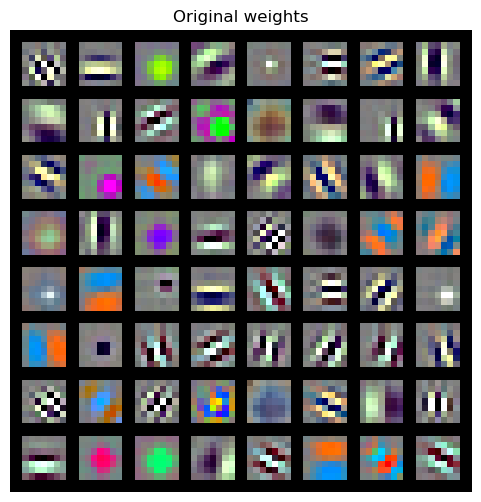

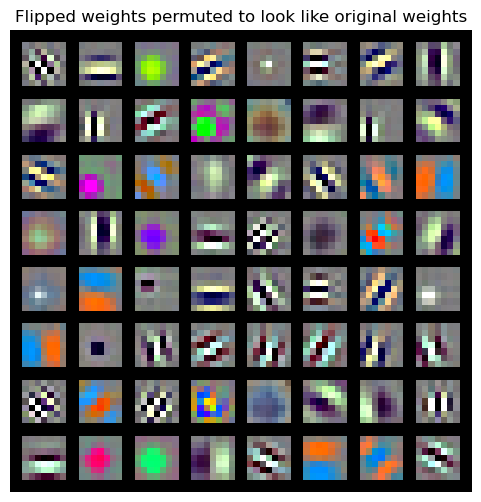

In [24]:
w1 = model0.conv1.weight.data.clone()
viz(w1, 'Original weights')
w2 = model1.conv1.weight.data.clone()
viz(w2, 'Flipped weights permuted to look like original weights')